In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
# Load dataset
file_path = "tmdb_popular_movies_dataset.csv"
df = pd.read_csv(file_path)

# Inspect the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())


       id original_language  \
0  939243                en   
1  762509                en   
2  558449                en   
3  912649                en   
4  539972                en   

                                            overview  popularity release_date  \
0  Sonic, Knuckles, and Tails reunite against a p...    2596.305   19-12-2024   
1  Mufasa, a cub lost and alone, meets a sympathe...    2430.703   18-12-2024   
2  Years after witnessing the death of the revere...    1662.393   05-11-2024   
3  Eddie and Venom are on the run. Hunted by both...    1638.713   22-10-2024   
4  Kraven Kravinoff's complex relationship with h...    2355.174   11-12-2024   

                   title  vote_average  vote_count  
0   Sonic the Hedgehog 3         7.564         637  
1  Mufasa: The Lion King         7.389         723  
2           Gladiator II         6.747        2369  
3  Venom: The Last Dance         6.800        2408  
4      Kraven the Hunter         6.302         494  
id      

                 id   popularity  vote_average    vote_count
count  9.923000e+03  9923.000000   9923.000000   9923.000000
mean   3.428234e+05    34.187475      6.379318   1794.561725
std    4.035091e+05    70.489656      1.343789   3202.218625
min    5.000000e+00     8.301000      0.000000      0.000000
25%    1.127050e+04    16.964500      5.974000    181.000000
50%    1.229060e+05    21.810000      6.570000    665.000000
75%    5.911965e+05    32.577500      7.139000   1890.000000
max    1.414642e+06  2596.305000     10.000000  36875.000000
original_language
en    7458
ja     535
ko     348
fr     301
es     247
it     142
zh     122
cn     120
de     102
tl      81
hi      55
ru      51
id      41
sv      33
pt      33
th      30
no      25
tr      23
da      23
nl      22
pl      18
ta      13
te      10
ml       9
fi       9
ar       7
uk       5
cs       5
fa       5
ca       4
he       4
is       4
el       4
sh       4
ms       4
sr       4
bn       3
kn       2
ku       2
hu  

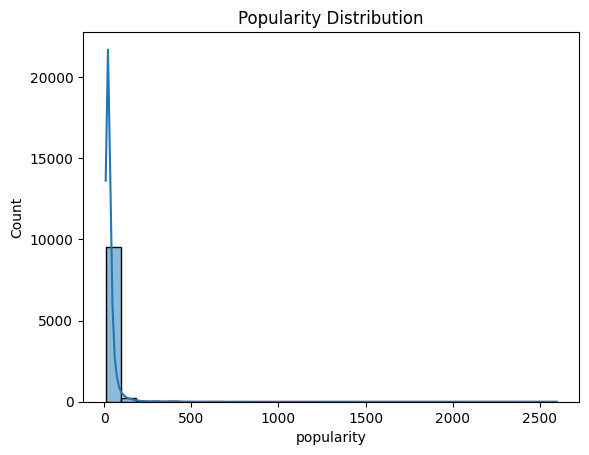

In [25]:
# Basic statistics
print(df.describe())

# Unique values in categorical columns
print(df['original_language'].value_counts())

# Popularity distribution
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Popularity Distribution")
plt.show()


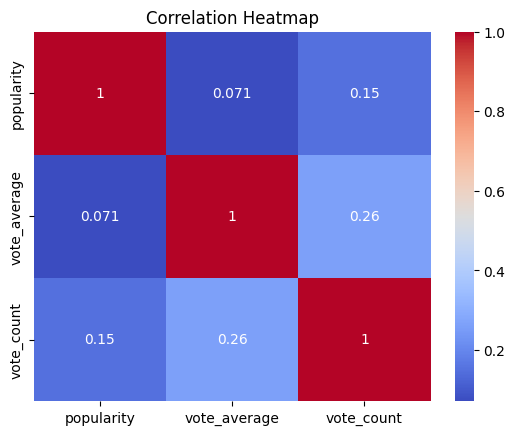

In [26]:
# Correlation heatmap
corr_matrix = df[['popularity', 'vote_average', 'vote_count']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


<ipython-input-27-827669249ce8>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
<ipython-input-27-827669249ce8>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='release_year', y='popularity', ci=None)


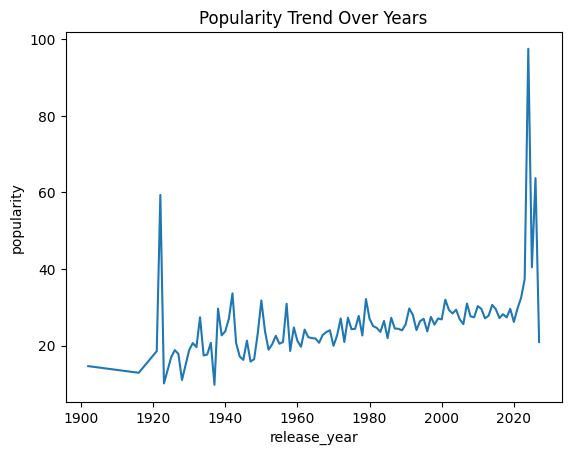

In [27]:
# Convert release_date to datetime and extract year
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

# Popularity over years
sns.lineplot(data=df, x='release_year', y='popularity', ci=None)
plt.title("Popularity Trend Over Years")
plt.show()


In [28]:
# One-hot encoding for original_language
df = pd.get_dummies(df, columns=['original_language'], drop_first=True)

In [40]:

# Display result
print(df.head())


       id                                           overview  popularity  \
0  939243  Sonic, Knuckles, and Tails reunite against a p...    2596.305   
1  762509  Mufasa, a cub lost and alone, meets a sympathe...    2430.703   
2  558449  Years after witnessing the death of the revere...    1662.393   
3  912649  Eddie and Venom are on the run. Hunted by both...    1638.713   
4  539972  Kraven Kravinoff's complex relationship with h...    2355.174   

  release_date                  title  vote_average  vote_count  release_year  \
0   19-12-2024   Sonic the Hedgehog 3         7.564         637          2024   
1   18-12-2024  Mufasa: The Lion King         7.389         723          2024   
2   05-11-2024           Gladiator II         6.747        2369          2024   
3   22-10-2024  Venom: The Last Dance         6.800        2408          2024   
4   11-12-2024      Kraven the Hunter         6.302         494          2024   

   original_language_bn  original_language_ca  ...  wron

In [29]:
# Text processing using TF-IDF
vectorizer = TfidfVectorizer(max_features=500, stop_words=stopwords.words('english'))
tfidf_matrix = vectorizer.fit_transform(df['overview'].fillna(""))

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df = pd.concat([df, tfidf_df], axis=1)


In [31]:
# Define features and target
X = df.drop(['id', 'title', 'release_date', 'overview', 'popularity'], axis=1)
y = df['popularity']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 Score:", r2_score(y_test, y_pred))


RMSE: 83.8455330800388
R^2 Score: 0.1664917609167369


In [47]:
# Compute similarity based on overview
similarity_matrix = cosine_similarity(tfidf_matrix)

# Recommend movies
def recommend_movies(movie_title, top_n=5):
    index = df[df['title'] == movie_title].index[0]
    similarity_scores = list(enumerate(similarity_matrix[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    recommended_indices = [i[0] for i in similarity_scores[1:top_n+1]]
    return df.iloc[recommended_indices][['title', 'popularity', 'vote_average']]

print(recommend_movies("Deadpool & Wolverine"))


                                                title  popularity  \
6133                     Once Upon a Time in China II      16.148   
2999  Chunin Exam on Fire! and Naruto vs. Konohamaru!      28.902   
4579                                Facing the Giants      23.143   
3416                    The Bridges of Madison County      29.211   
344                                Fifty Shades Freed     111.680   

      vote_average  
6133         7.136  
2999         7.400  
4579         7.500  
3416         7.714  
344          6.700  


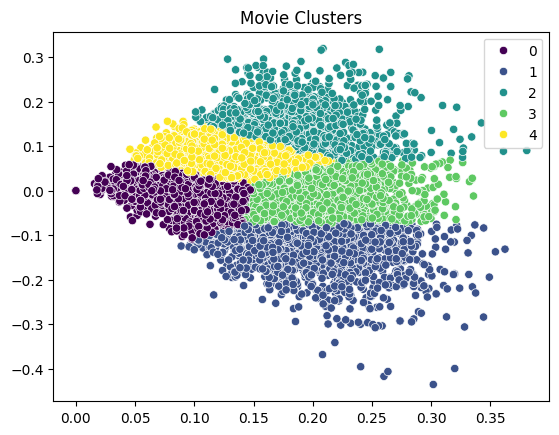

In [33]:
# Dimensionality reduction for clustering
svd = TruncatedSVD(n_components=2)
reduced_features = svd.fit_transform(tfidf_matrix)

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

# Add clusters to DataFrame
df['cluster'] = clusters

# Plot clusters
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=clusters, palette="viridis")
plt.title("Movie Clusters")
plt.show()

<ipython-input-34-b21f95fd6825>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=df, palette='coolwarm')


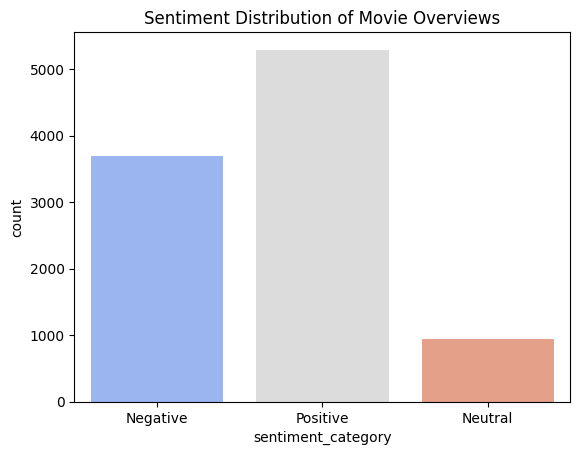

In [34]:
from textblob import TextBlob

# Add a sentiment score column
df['sentiment'] = df['overview'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)

# Categorize sentiment
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

# Plot sentiment distribution
sns.countplot(x='sentiment_category', data=df, palette='coolwarm')
plt.title("Sentiment Distribution of Movie Overviews")
plt.show()

<ipython-input-35-6395f6ed3671>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year


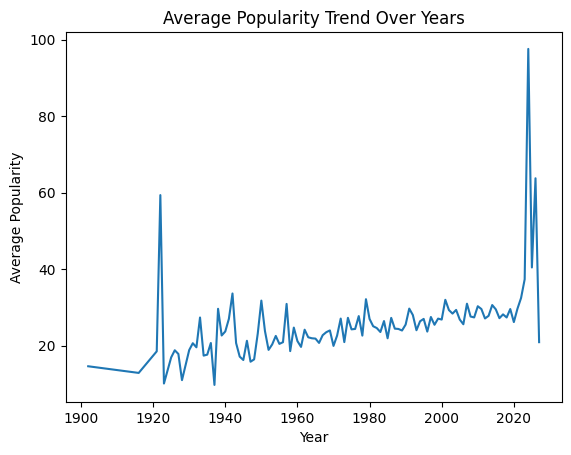

In [35]:
# Convert release_date to datetime and extract year
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

# Group by year and calculate mean popularity
popularity_trend = df.groupby('release_year')['popularity'].mean().reset_index()

# Plot the trend
sns.lineplot(x='release_year', y='popularity', data=popularity_trend)
plt.title("Average Popularity Trend Over Years")
plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.show()


In [43]:
# Group by language and calculate average popularity and vote_average
# Since original_language is one-hot encoded, you need to group by the generated columns
# Get a list of columns that start with 'original_language_'
language_columns = [col for col in df.columns if col.startswith('original_language_')]

# Group by these columns
language_insights = df.groupby(language_columns)[['popularity', 'vote_average', 'vote_count']].mean().reset_index()

# Extract language names from column names
language_insights['original_language'] = language_insights[language_columns].idxmax(axis=1).str.replace('original_language_', '')

# Proceed with sorting and display
language_insights = language_insights.sort_values(by='popularity', ascending=False)

# Display top languages
print(language_insights[['original_language', 'popularity', 'vote_average', 'vote_count']])

   original_language  popularity  vote_average   vote_count
3                 xx  478.218000      6.100000    29.000000
22                lv  336.065500      4.200000   393.500000
18                no   77.294600      6.331560   442.000000
9                 te   68.359700      6.174500   329.100000
19                nl   62.121227      6.626591   242.454545
42                es   45.103761      6.629603   587.485830
17                pl   39.450056      6.225611   284.222222
44                el   38.614750      6.471750   734.000000
5                 uk   38.256000      7.111800   361.000000
12                sr   38.131500      7.023500   858.500000
21                ml   37.817444      6.389556    19.000000
23                lt   37.640000      5.200000  2192.000000
37                ga   36.476000      6.925000    93.000000
16                pt   36.172758      6.334333   479.545455
38                fr   35.451668      6.611691   830.554817
43                en   34.392553      6.

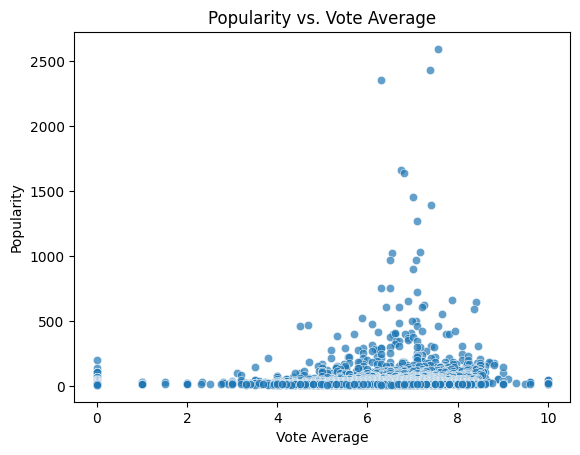

In [44]:
sns.scatterplot(x='vote_average', y='popularity', data=df, alpha=0.7)
plt.title("Popularity vs. Vote Average")
plt.xlabel("Vote Average")
plt.ylabel("Popularity")
plt.show()


In [45]:
import spacy

# Load Spacy's English model
nlp = spacy.load("en_core_web_sm")

# Define a function to extract named entities
def extract_entities(text):
    if isinstance(text, str):
        doc = nlp(text)
        return [(ent.text, ent.label_) for ent in doc.ents]
    return []

# Apply NER on the overview column
df['entities'] = df['overview'].apply(extract_entities)

# Display the extracted entities
print(df[['title', 'entities']].head())


                   title                                           entities
0   Sonic the Hedgehog 3  [(Sonic, ORG), (Knuckles, PERSON), (Shadow, PR...
1  Mufasa: The Lion King                    [(Mufasa, GPE), (Taka, PERSON)]
2           Gladiator II  [(Years, DATE), (Maximus, GPE), (Lucius, PERSO...
3  Venom: The Last Dance  [(Eddie, GPE), (Venom, GPE), (Venom, GPE), (Ed...
4      Kraven the Hunter  [(Kraven Kravinoff's, PERSON), (Nikolai, PERSON)]


In [46]:
from textblob import TextBlob

# Function to extract sentiment associated with a specific entity
def entity_sentiment(text, target_entity):
    if isinstance(text, str):
        doc = nlp(text)
        sentences = [sent.text for sent in doc.sents if target_entity in sent.text]
        sentiments = [TextBlob(sentence).sentiment.polarity for sentence in sentences]
        return np.mean(sentiments) if sentiments else 0
    return 0

# Example: Sentiment analysis for the entity "Sonic"
df['sonic_sentiment'] = df['overview'].apply(lambda x: entity_sentiment(x, "Sonic"))

# Display sentiment values
print(df[['title', 'sonic_sentiment']].head())


                   title  sonic_sentiment
0   Sonic the Hedgehog 3        -0.177273
1  Mufasa: The Lion King         0.000000
2           Gladiator II         0.000000
3  Venom: The Last Dance         0.000000
4      Kraven the Hunter         0.000000


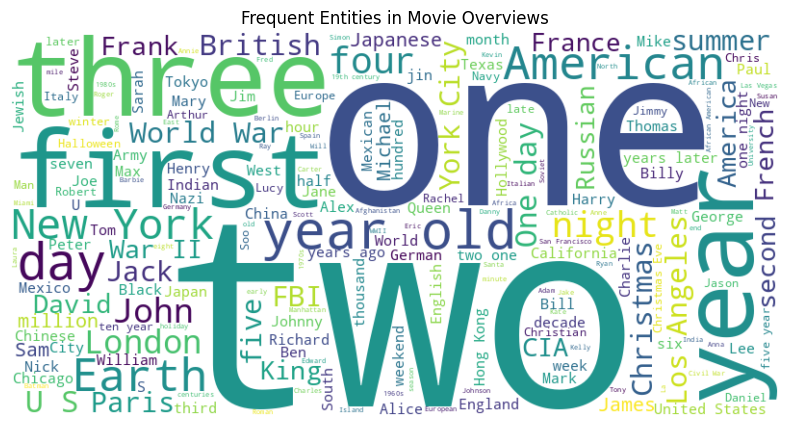

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all entities into a single string
entity_text = " ".join([ent[0] for ents in df['entities'] if isinstance(ents, list) for ent in ents])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(entity_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Entities in Movie Overviews")
plt.show()


In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor

# Extract named entities as text
df['entity_text'] = df['entities'].apply(lambda ents: " ".join([ent[0] for ent in ents]) if isinstance(ents, list) else "")

# Convert entities to feature vectors
vectorizer = CountVectorizer(max_features=500)
entity_features = vectorizer.fit_transform(df['entity_text'])

# Combine with existing features
X = pd.concat([pd.DataFrame(entity_features.toarray(), columns=vectorizer.get_feature_names_out()),
                df[['vote_count', 'vote_average']]], axis=1)
y = df['popularity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


RMSE: 93.47484498719045


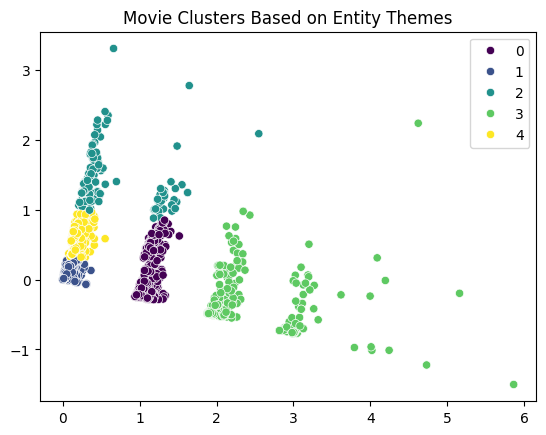

In [50]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

# Reduce dimensionality of entity feature vectors
svd = TruncatedSVD(n_components=2)
reduced_features = svd.fit_transform(entity_features)

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

# Add cluster labels to the dataset
df['entity_cluster'] = clusters

# Visualize clusters
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=clusters, palette="viridis")
plt.title("Movie Clusters Based on Entity Themes")
plt.show()
